In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from torch.utils.data import DataLoader, TensorDataset,random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
reconstructed_images = torch.load('/kaggle/input/limited-helsinki/scaled_recon90deg181.pt')
ground_truth_images = torch.load('/kaggle/input/limited-helsinki/scaled_ground90deg181.pt')
ground_truth_images = ground_truth_images.view(-1,1,512,512)
reconstructed_images = reconstructed_images.view(-1,1,512,512)
dataset = TensorDataset(reconstructed_images ,ground_truth_images)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(len(train_dataset))
print(len(test_dataset))
# Create data loaders

3200
800


In [3]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False,drop_last=True)

In [4]:
!pip install torchmetrics

In [5]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ArtifactRemovalResNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_blocks=8):
        super(ArtifactRemovalResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.residual_blocks = self.make_residual_blocks(64, num_blocks)

        self.conv2 = nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

    def make_residual_blocks(self, channels, num_blocks):
        blocks = []
        for _ in range(num_blocks):
            blocks.append(ResidualBlock(channels, channels))
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.residual_blocks(out)

        out = self.conv2(out)

        return out


In [6]:
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ArtifactRemovalResNet(in_channels=1 , out_channels=1).to(device)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
training_losses = []
val_losses = []

In [8]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    for data in tqdm(train_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        training_loss += loss.item()
        loss.backward()
        optimizer.step()
    average_loss = training_loss/len(train_loader)
    training_losses.append(average_loss)
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            outputs = model(inputs.to(device).float())
            loss = criterion(outputs, targets.to(device).float())
            total_val_loss += loss.item()
    average_val_loss = total_val_loss / len(test_loader)
    val_losses.append(average_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_loss:.6f}, Validation Loss: {average_val_loss:.6f}')
torch.save(model.state_dict(), 'resnetonLimHel4000.pth')

100%|██████████| 200/200 [00:28<00:00,  6.93it/s]


Epoch [1/10], Training Loss: 0.032034, Validation Loss: 0.005155


100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


Epoch [2/10], Training Loss: 0.005075, Validation Loss: 0.003844


100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


Epoch [3/10], Training Loss: 0.003886, Validation Loss: 0.004199


100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


Epoch [4/10], Training Loss: 0.003127, Validation Loss: 0.002447


100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


Epoch [5/10], Training Loss: 0.002684, Validation Loss: 0.002432


100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


Epoch [6/10], Training Loss: 0.002371, Validation Loss: 0.002175


100%|██████████| 200/200 [00:28<00:00,  6.95it/s]


Epoch [7/10], Training Loss: 0.002078, Validation Loss: 0.002325


100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


Epoch [8/10], Training Loss: 0.001923, Validation Loss: 0.001914


100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


Epoch [9/10], Training Loss: 0.001789, Validation Loss: 0.001577


100%|██████████| 200/200 [00:28<00:00,  6.94it/s]

Epoch [10/10], Training Loss: 0.001572, Validation Loss: 0.001558


In [10]:
print(training_losses)
print(val_losses)

[0.032034083654289135, 0.005074734649970197, 0.0038856737400055864, 0.0031272085590171627, 0.0026838722624233924, 0.0023713720742671285, 0.0020784504257608206, 0.0019225427829951513, 0.0017889946491777664, 0.0015723433741368354]
[0.0051547956536524, 0.003844477162929252, 0.004198515177704394, 0.002447314311284572, 0.002431655603577383, 0.002174782636575401, 0.0023252204270102082, 0.0019142590480623767, 0.0015770970619632862, 0.0015579129059915431]


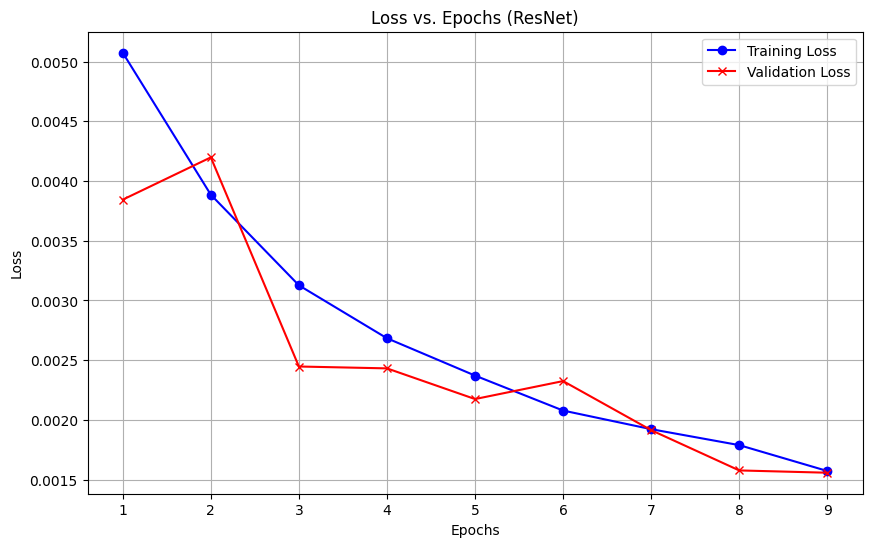

In [11]:
epochs = np.arange(1, num_epochs)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses[1:], marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(epochs, val_losses[1:], marker='x', linestyle='-', color='r', label='Validation Loss')
plt.title('Loss vs. Epochs (ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

100%|██████████| 200/200 [01:01<00:00,  3.25it/s]


Average SSIM: 0.5691
Average PSNR: 19.0049
Average SSIM: 0.3867
Average PSNR: 9.7275


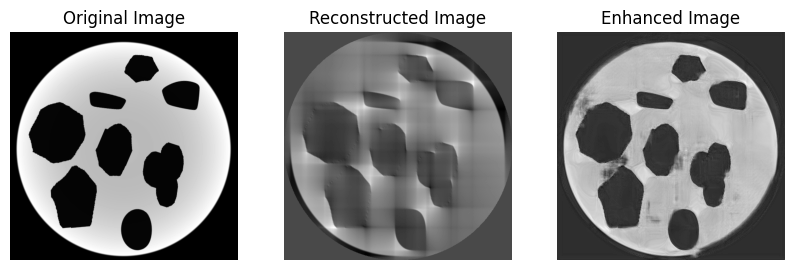

In [13]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Function to calculate SSIM for a batch of images
def batch_ssim(enhanced_images, ground_truth_images):
    ssim_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = ssim(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Function to calculate PSNR for a batch of images
def batch_psnr(enhanced_images, ground_truth_images):
    psnr_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = psnr(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        psnr_scores.append(score)
    return np.mean(psnr_scores)

# Evaluate the model and calculate SSIM and PSNR
model.eval()
all_ssim_scores = []
all_psnr_scores = []
recon_ssim = []
recon_psnr = []
printed = False
with torch.no_grad():
    for batch_reconstructed_images, batch_ground_truth_images in tqdm(test_loader):
        batch_reconstructed_images = batch_reconstructed_images.to(device).float()
        batch_ground_truth_images = batch_ground_truth_images.to(device).float()
        enhanced_images = model(batch_reconstructed_images)
        if printed == False:
          printed = True
          plt.figure(figsize=(10,5))
          plt.subplot(131)
          plt.axis("off")
          plt.title("Original Image")
          plt.imshow(batch_ground_truth_images[0][0].cpu(),cmap='gray')
          plt.subplot(132)
          plt.axis("off")
          plt.title("Reconstructed Image")
          plt.imshow(batch_reconstructed_images[0][0].cpu(),cmap='gray')
          plt.subplot(133)
          plt.axis("off")
          plt.title("Enhanced Image")
          plt.imshow(enhanced_images[0][0].cpu(),cmap='gray')
        all_ssim_scores.append(batch_ssim(enhanced_images, batch_ground_truth_images))
        all_psnr_scores.append(batch_psnr(enhanced_images, batch_ground_truth_images))

        recon_ssim.append(batch_ssim(batch_reconstructed_images, batch_ground_truth_images))
        recon_psnr.append(batch_psnr(batch_reconstructed_images, batch_ground_truth_images))
        # break

# Calculate average SSIM and PSNR
avg_ssim = np.mean(all_ssim_scores)
avg_psnr = np.mean(all_psnr_scores)
rec_ssim = np.mean(recon_ssim)
rec_psnr = np.mean(recon_psnr)
print(f'Average SSIM: {avg_ssim:.4f}')
print(f'Average PSNR: {avg_psnr:.4f}')
print(f'Average SSIM: {rec_ssim:.4f}')
print(f'Average PSNR: {rec_psnr:.4f}')



In [14]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  593152


In [ ]:
print(model)